# Import Necessary Modules

In [1]:
import tensorflow as tf
from tensorflow import keras

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import numpy as np
import os

from ncps.wirings import AutoNCP
from ncps.tf import LTC

from scipy.io import loadmat
import sklearn
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

In [3]:
# Read data from MATLAB file
matfile = loadmat('Data\TrainingData_20230314-112821_113353_SJ_Pilot_03_14_10-Aug-2023_12-29-43.mat');

x = np.array(matfile['data'])
y = np.array(matfile['labels'])
windowSize = matfile['windowSize']
numFeatures = matfile['numFeatures']

x = np.transpose(x, (0, 2, 1))
y = np.transpose(y)

print(x.shape)
print(y.shape)

(8194, 25, 528)
(8194, 1)


In [4]:
batchSize = 5
xWindows = np.zeros([x.shape[0], batchSize, x.shape[1], x.shape[2]])
yWindows = np.zeros([y.shape[0], batchSize, y.shape[1]])

for i in range(batchSize, x.shape[0]):
    for j in range(batchSize):
        xWindows[i-1, j, :, :] = x[i-batchSize, :, :]
        yWindows[i-1, j, :] = y[i-batchSize, :]

xWindows = xWindows[batchSize-1:, :, :, :]
yWindows = yWindows[batchSize-1:, :, :]

# Resize data to correct shape
xWindows = np.reshape(xWindows, [xWindows.shape[0],xWindows.shape[1],xWindows.shape[2],xWindows.shape[3],1])

yWindows[yWindows == 10] = 2
yWindows[yWindows == 12] = 3

print(xWindows.shape)
print(yWindows.shape)

(8190, 5, 25, 528, 1)
(8190, 5, 1)


In [5]:
# Make train, validation, test sets
train_x, test_x, train_y, test_y = train_test_split(xWindows, yWindows, test_size=0.2, random_state=42)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.25, random_state=42)

print(train_x.shape)
print(val_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)
print(val_y.shape)

(4914, 5, 25, 528, 1)
(1638, 5, 25, 528, 1)
(1638, 5, 25, 528, 1)
(4914, 5, 1)
(1638, 5, 1)
(1638, 5, 1)


# Build Model

In [6]:
height, width, channels = (train_x.shape[2], train_x.shape[3], train_x.shape[4])

wiring = AutoNCP(20, output_size=4)

model = tf.keras.models.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(None, height, width, channels)),
        tf.keras.layers.Normalization(),
        tf.keras.layers.TimeDistributed(
            tf.keras.layers.Conv2D(64, (3,3))
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool2D()),
        tf.keras.layers.TimeDistributed(
            tf.keras.layers.Conv2D(32, (3,3))
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool2D()),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32)),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.2),
        LTC(wiring, return_sequences=True),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Activation("softmax")),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate = 0.01, momentum=0.9),
    loss='sparse_categorical_crossentropy',
    metrics='accuracy'
)

model.summary(line_length=100)

Model: "sequential"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 normalization (Normalization)               (None, None, 25, 528, 1)                3              
                                                                                                    
 time_distributed (TimeDistributed)          (None, None, 23, 526, 64)               640            
                                                                                                    
 batch_normalization (BatchNormalization)    (None, None, 23, 526, 64)               256            
                                                                                                    
 time_distributed_1 (TimeDistributed)        (None, None, 11, 263, 64)               0              
                                                                       

C:\Users\Aaron Wang\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


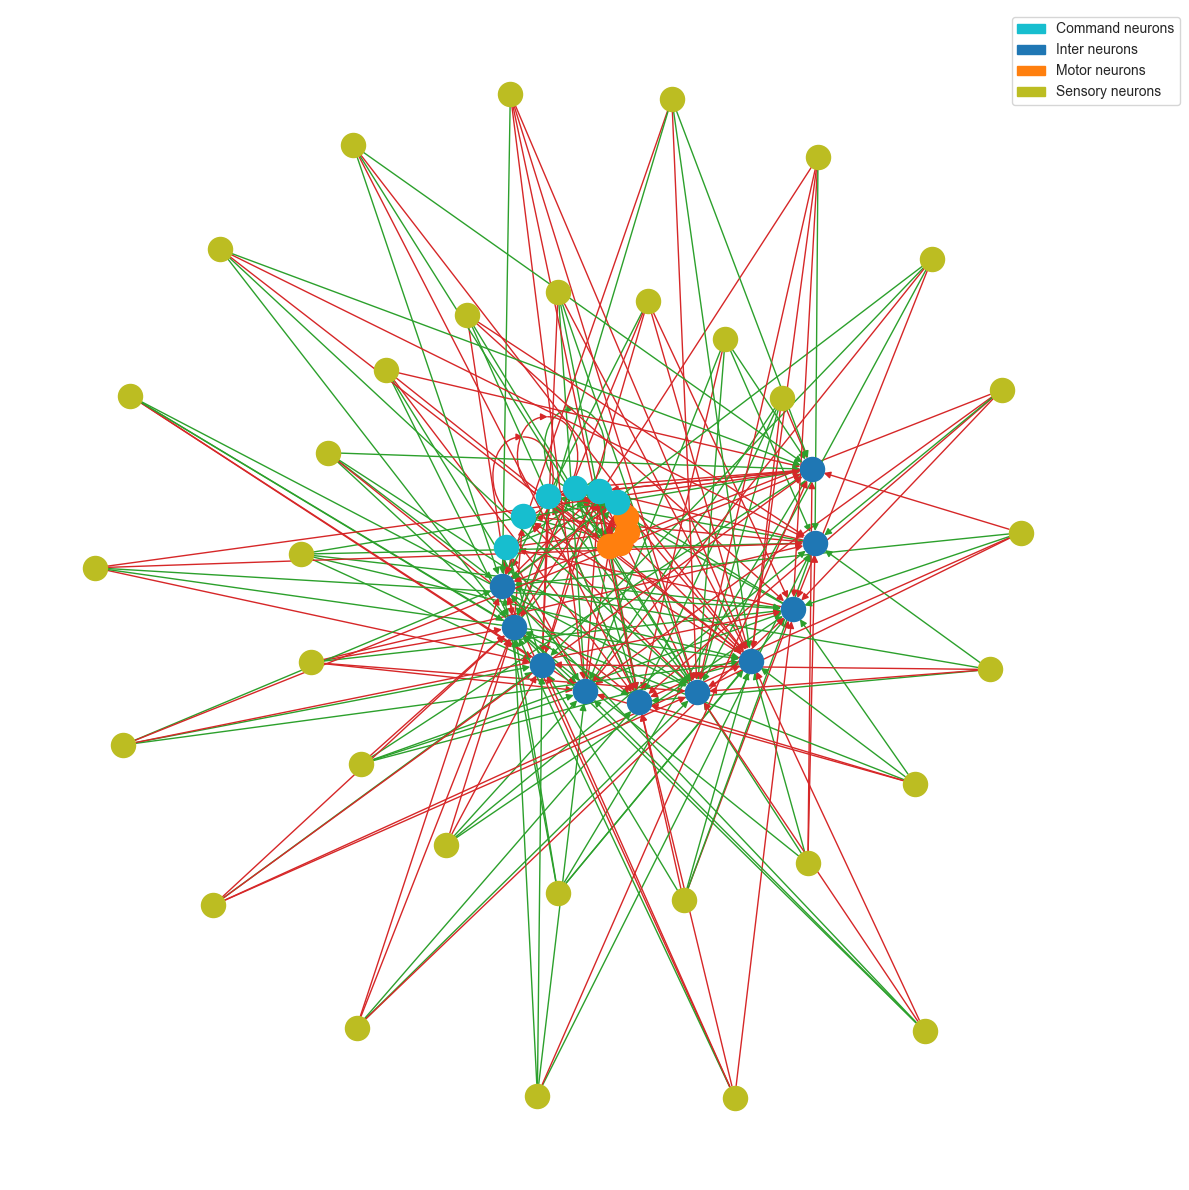

In [7]:
sns.set_style("white")
plt.figure(figsize=(12, 12))
legend_handles = wiring.draw_graph(layout='spiral',neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

# Train Model

In [8]:
model.evaluate(val_x, val_y)

52/52 [==============================] - 7s 42ms/step - loss: 1.3899 - accuracy: 0.1255


[1.3898959159851074, 0.12551893293857574]

In [9]:
history = model.fit(
    x=train_x, y=train_y, batch_size=32, epochs=30, validation_data=(val_x, val_y)
)

Epoch 1/30
154/154 [==============================] - 57s 308ms/step - loss: 1.2264 - accuracy: 0.4669 - val_loss: 1.1421 - val_accuracy: 0.5563
Epoch 2/30
154/154 [==============================] - 47s 304ms/step - loss: 1.1192 - accuracy: 0.5397 - val_loss: 1.0704 - val_accuracy: 0.5822
Epoch 3/30
154/154 [==============================] - 48s 312ms/step - loss: 1.1158 - accuracy: 0.5319 - val_loss: 1.0421 - val_accuracy: 0.5883
Epoch 4/30
154/154 [==============================] - 48s 311ms/step - loss: 1.0723 - accuracy: 0.5460 - val_loss: 1.1260 - val_accuracy: 0.5195
Epoch 5/30
154/154 [==============================] - 47s 308ms/step - loss: 1.0901 - accuracy: 0.5462 - val_loss: 1.0897 - val_accuracy: 0.5325
Epoch 6/30
154/154 [==============================] - 48s 314ms/step - loss: 1.0716 - accuracy: 0.5456 - val_loss: 0.9410 - val_accuracy: 0.6254
Epoch 7/30
154/154 [==============================] - 47s 304ms/step - loss: 0.9836 - accuracy: 0.5768 - val_loss: 1.1671 - val_ac

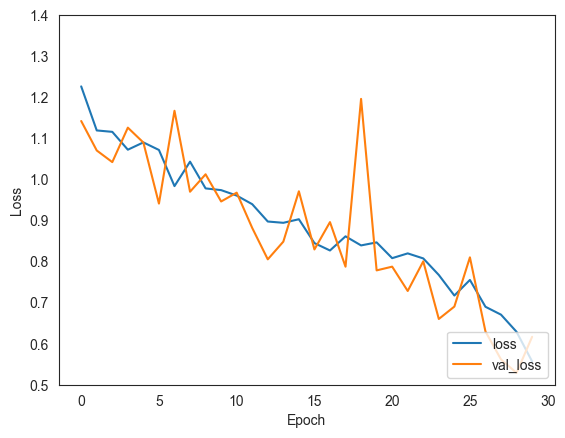

In [10]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.5, 1.4])
plt.legend(loc='lower right')

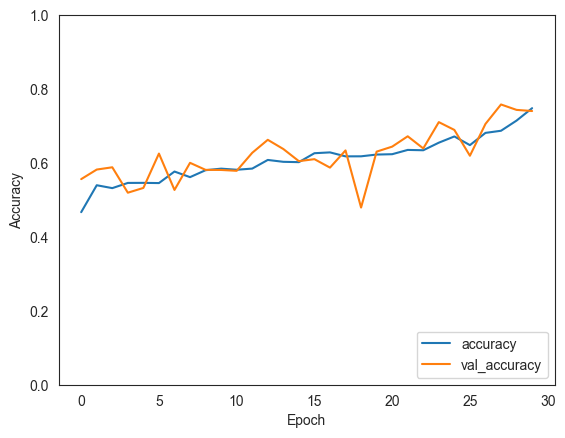

In [12]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

# Evaluate Model

In [13]:
val_loss, val_acc = model.evaluate(val_x, val_y)

print("Validation Loss: {}".format(val_loss))
print("Validation Accuracy: {}".format(val_acc))

52/52 [==============================] - 3s 42ms/step - loss: 0.6167 - accuracy: 0.7405
Validation Loss: 0.6166509985923767
Validation Accuracy: 0.7405372262001038


In [14]:
test_loss, test_acc = model.evaluate(test_x, test_y)

print("Test Loss: {}".format(test_loss))
print("Test Accuracy: {}".format(test_acc))

52/52 [==============================] - 2s 43ms/step - loss: 0.5523 - accuracy: 0.7737
Test Loss: 0.5523139238357544
Test Accuracy: 0.7737484574317932


# Train for 20 More Epochs

In [15]:
history_2 = model.fit(
    x=train_x, y=train_y, batch_size=32, epochs=20, validation_data=(val_x, val_y)
)

Epoch 1/20
154/154 [==============================] - 48s 308ms/step - loss: 0.6699 - accuracy: 0.6967 - val_loss: 0.6095 - val_accuracy: 0.7184
Epoch 2/20
154/154 [==============================] - 47s 303ms/step - loss: 0.6435 - accuracy: 0.7090 - val_loss: 0.5822 - val_accuracy: 0.7072
Epoch 3/20
154/154 [==============================] - 47s 306ms/step - loss: 0.6744 - accuracy: 0.6895 - val_loss: 0.5575 - val_accuracy: 0.7413
Epoch 4/20
154/154 [==============================] - 47s 305ms/step - loss: 0.6153 - accuracy: 0.7250 - val_loss: 0.5251 - val_accuracy: 0.7844
Epoch 5/20
154/154 [==============================] - 47s 302ms/step - loss: 0.5584 - accuracy: 0.7501 - val_loss: 0.5527 - val_accuracy: 0.7607
Epoch 6/20
154/154 [==============================] - 47s 308ms/step - loss: 0.5950 - accuracy: 0.7487 - val_loss: 0.5243 - val_accuracy: 0.7864
Epoch 7/20
154/154 [==============================] - 47s 304ms/step - loss: 0.5338 - accuracy: 0.7555 - val_loss: 0.5096 - val_ac

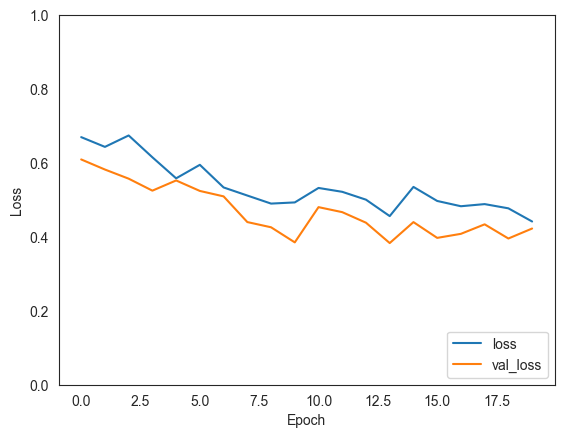

In [21]:
plt.plot(history_2.history['loss'], label='loss')
plt.plot(history_2.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

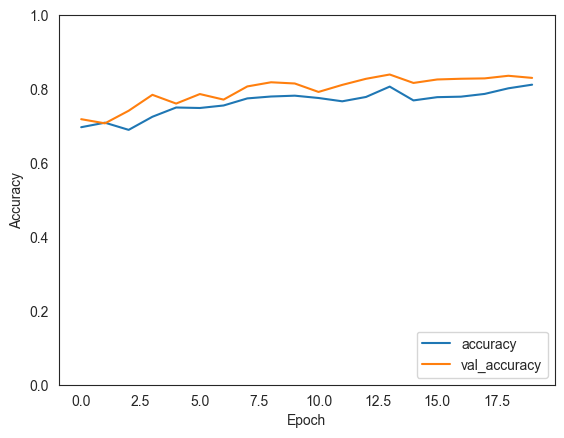

In [22]:
plt.plot(history_2.history['accuracy'], label='accuracy')
plt.plot(history_2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

# Evaluate Model

In [18]:
val_loss, val_acc = model.evaluate(val_x, val_y)

print("Validation Loss: {}".format(val_loss))
print("Validation Accuracy: {}".format(val_acc))

52/52 [==============================] - 2s 43ms/step - loss: 0.4226 - accuracy: 0.8302
Validation Loss: 0.4225916862487793
Validation Accuracy: 0.8301587104797363


In [19]:
test_loss, test_acc = model.evaluate(test_x, test_y)

print("Test Loss: {}".format(test_loss))
print("Test Accuracy: {}".format(test_acc))

52/52 [==============================] - 2s 43ms/step - loss: 0.3840 - accuracy: 0.8496
Test Loss: 0.38401782512664795
Test Accuracy: 0.8495726585388184


# Save Model

In [20]:
model.save('D:/SmartHome/LNNModels/cnnltc1.keras')

# Train for 25 More Epochs

In [28]:
history_3 = model.fit(
    x=train_x, y=train_y, batch_size=32, epochs=25, validation_data=(val_x, val_y)
)

KeyboardInterrupt: 

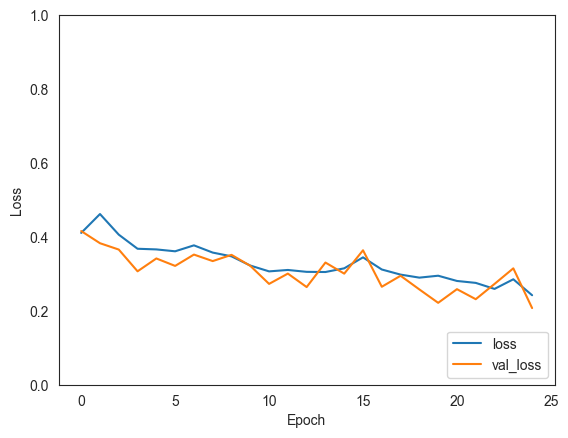

In [24]:
plt.plot(history_3.history['loss'], label='loss')
plt.plot(history_3.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

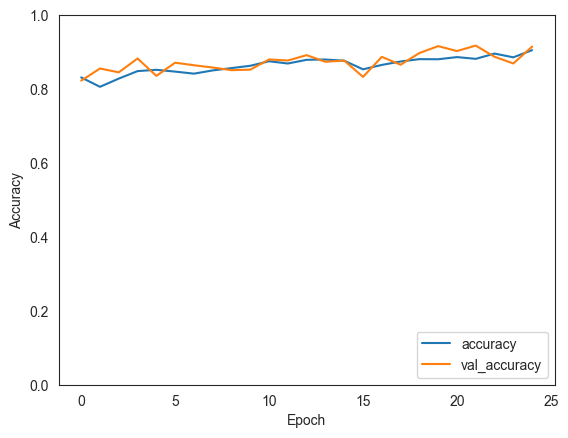

In [25]:
plt.plot(history_3.history['accuracy'], label='accuracy')
plt.plot(history_3.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [26]:
test_loss, test_acc = model.evaluate(test_x, test_y)

print("Test Loss: {}".format(test_loss))
print("Test Accuracy: {}".format(test_acc))

52/52 [==============================] - 3s 43ms/step - loss: 0.1937 - accuracy: 0.9249
Test Loss: 0.19371508061885834
Test Accuracy: 0.9249083995819092


In [27]:
model.save('D:/SmartHome/LNNModels/cnnltc1_75epochs.keras')

In [29]:
history_4 = model.fit(
    x=train_x, y=train_y, batch_size=32, epochs=25, validation_data=(val_x, val_y)
)

Epoch 1/25
154/154 [==============================] - 48s 309ms/step - loss: 0.2352 - accuracy: 0.9067 - val_loss: 0.2420 - val_accuracy: 0.8966
Epoch 2/25
154/154 [==============================] - 47s 302ms/step - loss: 0.2343 - accuracy: 0.9090 - val_loss: 0.3120 - val_accuracy: 0.8819
Epoch 3/25
154/154 [==============================] - 47s 302ms/step - loss: 0.2451 - accuracy: 0.9069 - val_loss: 0.2517 - val_accuracy: 0.8978
Epoch 4/25
154/154 [==============================] - 47s 303ms/step - loss: 0.2534 - accuracy: 0.8986 - val_loss: 0.2497 - val_accuracy: 0.8941
Epoch 5/25
154/154 [==============================] - 47s 306ms/step - loss: 0.2584 - accuracy: 0.9000 - val_loss: 0.2345 - val_accuracy: 0.9074
Epoch 6/25
154/154 [==============================] - 47s 303ms/step - loss: 0.2141 - accuracy: 0.9203 - val_loss: 0.2256 - val_accuracy: 0.9151
Epoch 7/25
154/154 [==============================] - 47s 308ms/step - loss: 0.2273 - accuracy: 0.9126 - val_loss: 0.2352 - val_ac

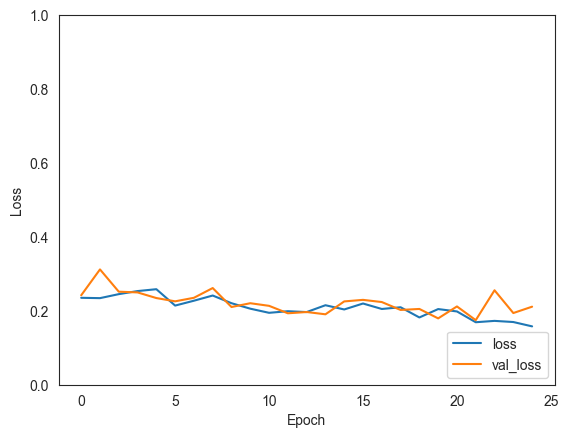

In [30]:
plt.plot(history_4.history['loss'], label='loss')
plt.plot(history_4.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

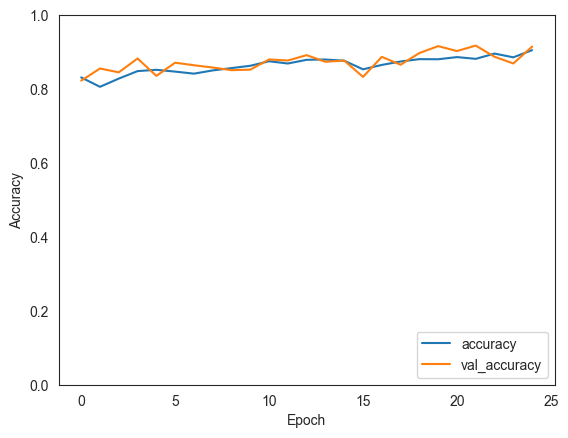

In [31]:
plt.plot(history_3.history['accuracy'], label='accuracy')
plt.plot(history_3.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [32]:
test_loss, test_acc = model.evaluate(test_x, test_y)

print("Test Loss: {}".format(test_loss))
print("Test Accuracy: {}".format(test_acc))

52/52 [==============================] - 2s 42ms/step - loss: 0.1723 - accuracy: 0.9389
Test Loss: 0.17228393256664276
Test Accuracy: 0.9389499425888062


In [33]:
model.save('D:/SmartHome/LNNModels/cnnltc1_75epochs.keras')